In [3]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix,precision_score
from sklearn.model_selection import train_test_split


In [ ]:
# =========================
# 2. LOAD DATA
# =========================
from dotenv import load_dotenv
import os
load_dotenv()
data_path = os.getenv("PATH")
df = pd.read_csv(data_path, index_col="PassengerId")

In [5]:

# =========================
# 3. HANDLE MISSING VALUES
# =========================

# Age → mean
df["Age"] = df["Age"].fillna(df["Age"].mean())

# Fare → convert to numeric + median
df["Fare"] = pd.to_numeric(df["Fare"], errors="coerce")
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Sex → mode
df["Sex"] = df["Sex"].fillna(df["Sex"].mode()[0])

# Embarked → mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Cabin → Deck extraction
df["Deck"] = df["Cabin"].str[0]
df["Deck"] = df["Deck"].fillna("Missing")
df.drop(columns=["Cabin"], inplace=True)

# Ticket → drop rows with missing ticket
df.dropna(subset=["Ticket"], inplace=True)


In [6]:

# =========================
# 4. ENCODING
# =========================
df_copy = df.copy()

# Label Encoding (Sex)
le = LabelEncoder()
df_copy["Sex_encoded"] = le.fit_transform(df_copy["Sex"])
df_copy.drop(columns=["Sex"], inplace=True)

# One-hot encoding (Embarked)
df_copy = pd.get_dummies(df_copy, columns=["Embarked"], drop_first=True)

# Convert bool → int
bool_cols = df_copy.select_dtypes(include="bool").columns
df_copy[bool_cols] = df_copy[bool_cols].astype(int)


In [7]:
# =========================
# 5. DROP STRING COLUMNS
# =========================
df_copy.drop(columns=["Name", "Ticket"], inplace=True)

In [8]:
# =========================
# 6. FORCE NUMERIC TYPES (CRITICAL FIX)
# =========================
df_copy["Pclass"] = pd.to_numeric(df_copy["Pclass"], errors="coerce")
df_copy["Parch"] = pd.to_numeric(df_copy["Parch"], errors="coerce")

In [9]:
# =========================
# 7. DEFINE FEATURES & TARGET
# =========================
X = df_copy[
    ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_encoded", "Embarked_Q", "Embarked_S"]
]

y = df_copy["Survived"]
X = X.dropna()
y = y.loc[X.index]

In [10]:
# =========================
# 8. TRAIN TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = RandomForestClassifier(
    n_estimators=300,        # no. of trees
    criterion="gini",        # how splits are chosen
    max_depth=5,             # limits complexity
    min_samples_split=10,    # avoids splitting tiny nodes
    min_samples_leaf=5,      # avoids tiny leaves
    random_state=42
)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [11]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))

Accuracy : 0.8156424581005587
F1 Score : 0.7555555555555555
Precision: 0.8360655737704918
Recall   : 0.6891891891891891


       Feature  Importance
5  Sex_encoded    0.472401
4         Fare    0.166878
0       Pclass    0.146717
1          Age    0.103978
2        SibSp    0.044810
3        Parch    0.032819
7   Embarked_S    0.026003
6   Embarked_Q    0.006394


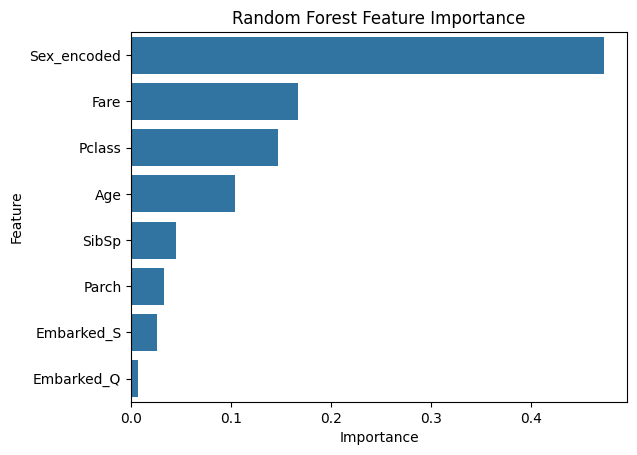

In [12]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp)
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Random Forest Feature Importance")
plt.show()


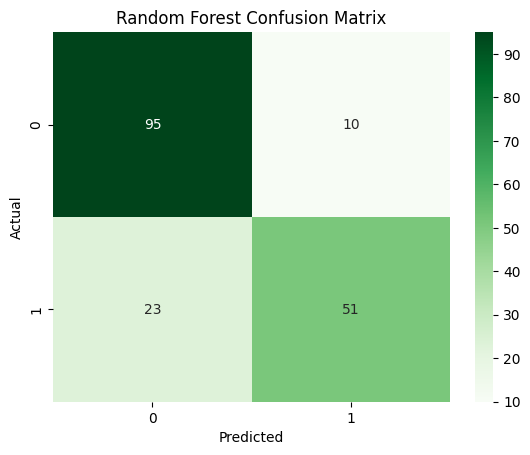

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [15]:
import joblib

# Save trained Random Forest model
joblib.dump(model, "random_forest_model.pkl")




['random_forest_model.pkl']